In [200]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import feature_selection, model_selection, metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgbm
import xgboost as xgb

In [201]:
train_data = pd.read_csv('train.csv', index_col='PassengerId')
test_data = pd.read_csv('test.csv', index_col='PassengerId')
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


# EDA

# 1.1. Overview

In [202]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [203]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [204]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [205]:
test_data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


# 1.2. Missing values

# Train data

In [206]:
all_features_train = train_data.columns.to_list()
nan_values_train = {}

for feature in all_features_train:
    num_nan_values = train_data[feature].isna().sum()
    nan_values_train[feature] = num_nan_values

print(nan_values_train)

{'Survived': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 0, 'Cabin': 687, 'Embarked': 2}


1.2.1. Age

In [207]:
# filling out 'Age' NaNs with median values based on Pclass and Sex
median_age = train_data.groupby(['Pclass', 'Sex'])['Age'].median()

for pclass in range(1,4):
    for sex in ['female', 'male']:
        print(f"Median age of Pclass {pclass} {sex}: {median_age[pclass, sex]}")

train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

Median age of Pclass 1 female: 35.0
Median age of Pclass 1 male: 40.0
Median age of Pclass 2 female: 28.0
Median age of Pclass 2 male: 30.0
Median age of Pclass 3 female: 21.5
Median age of Pclass 3 male: 25.0


1.2.2. Embarked

In [208]:
# filling out 'Embarked' NaNs with most common value
train_data['Embarked'] = train_data['Embarked'].fillna('S')

1.2.3. Cabin

In [209]:
# removing feature 'Cabin', because more than 80% values are missing
train_data = train_data.drop(columns=['Cabin'])

# Test data

In [210]:
all_features_test = test_data.columns.to_list()
nan_values_test = {}

for feature in all_features_test:
    num_nan_values = test_data[feature].isna().sum()
    nan_values_test[feature] = num_nan_values

print(nan_values_test)

{'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 86, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 1, 'Cabin': 327, 'Embarked': 0}


1.2.1. Age

In [211]:
# filling out 'Age' NaNs with median train values based on Pclass and Sex
test_data['Age'] = test_data.apply(lambda row: median_age[row['Pclass'], row['Sex']] if pd.isnull(row['Age']) else row['Age'], axis=1)

1.2.2. Fare

In [212]:
test_data[test_data['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [213]:
# filling out 'Fare' NaN with median value based on Pclass and Sex for this person
median_fare = train_data.groupby(['Pclass', 'Sex'])['Fare'].median()[3, 'male']
test_data['Fare'] = test_data['Fare'].fillna(median_fare)

1.2.3. Cabin

In [214]:
# removing feature 'Cabin', because more than 80% values are missing
test_data = test_data.drop(columns=['Cabin'])

# 1.3. Some EDA in order to understand the data

* Numerical feature distributions

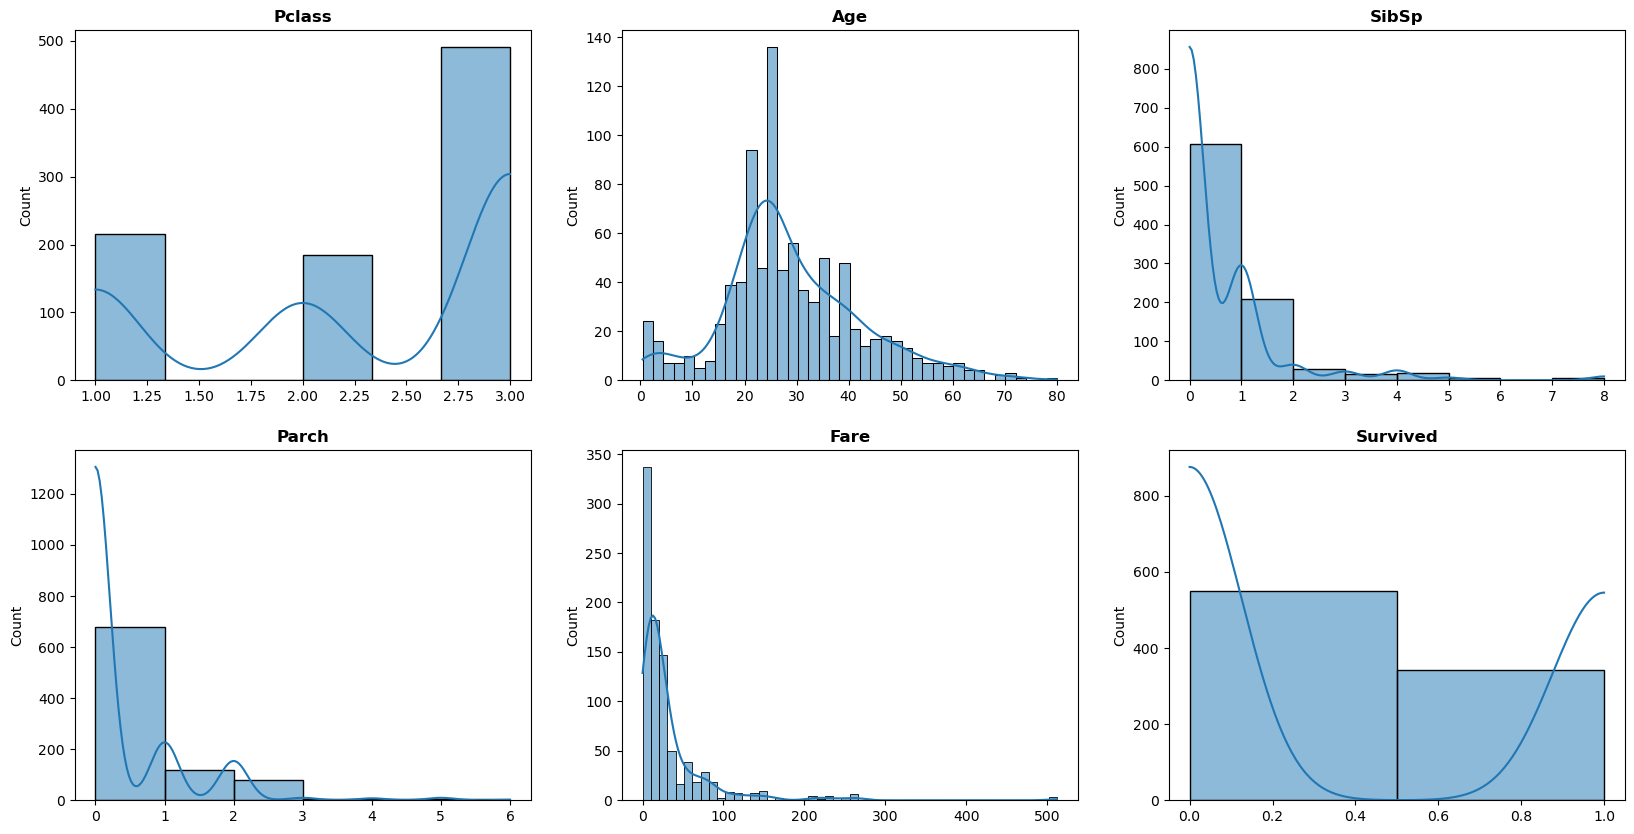

In [215]:
_, axis = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
sns.histplot(train_data['Pclass'], bins=6, kde=True, ax=axis[0,0])
axis[0,0].set_title('Pclass', fontweight='bold')
axis[0,0].set_xlabel('')

sns.histplot(train_data['Age'], bins=40, kde=True, ax=axis[0,1])
axis[0,1].set_title('Age', fontweight='bold')
axis[0,1].set_xlabel('')

sns.histplot(train_data['SibSp'], bins=8, kde=True, ax=axis[0,2])
axis[0,2].set_title('SibSp', fontweight='bold')
axis[0,2].set_xlabel('')

sns.histplot(train_data['Parch'], bins=6, kde=True, ax=axis[1,0])
axis[1,0].set_title('Parch', fontweight='bold')
axis[1,0].set_xlabel('')

sns.histplot(train_data['Fare'], bins=50, kde=True, ax=axis[1,1])
axis[1,1].set_title('Fare', fontweight='bold')
axis[1,1].set_xlabel('')

# Target distribution
sns.histplot(train_data['Survived'], bins=2, kde=True, ax=axis[1,2])
axis[1,2].set_title('Survived', fontweight='bold')
axis[1,2].set_xlabel('')

plt.show()

* Categorical features

In [216]:
unique_values = {}
categorical_features = ['Name', 'Sex', 'Ticket', 'Embarked']

for cat_feature in categorical_features:
    unique_n = train_data[cat_feature].nunique()
    unique_values[cat_feature] = unique_n

print(unique_values)

{'Name': 891, 'Sex': 2, 'Ticket': 681, 'Embarked': 3}


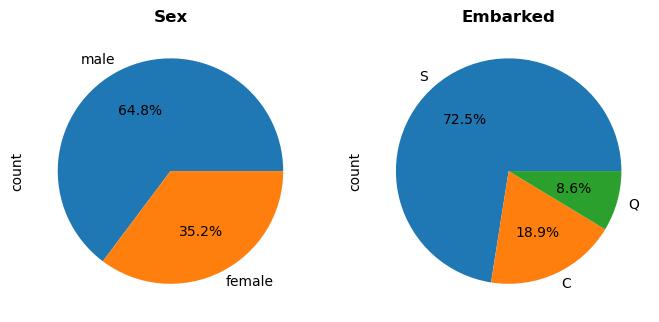

In [217]:
_, axis = plt.subplots(ncols=2, figsize=(8,4))
train_data['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axis[0])
axis[0].set_title('Sex', fontweight='bold')

train_data['Embarked'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axis[1])
axis[1].set_title('Embarked', fontweight='bold')
plt.show()

# 1.4. Correlations

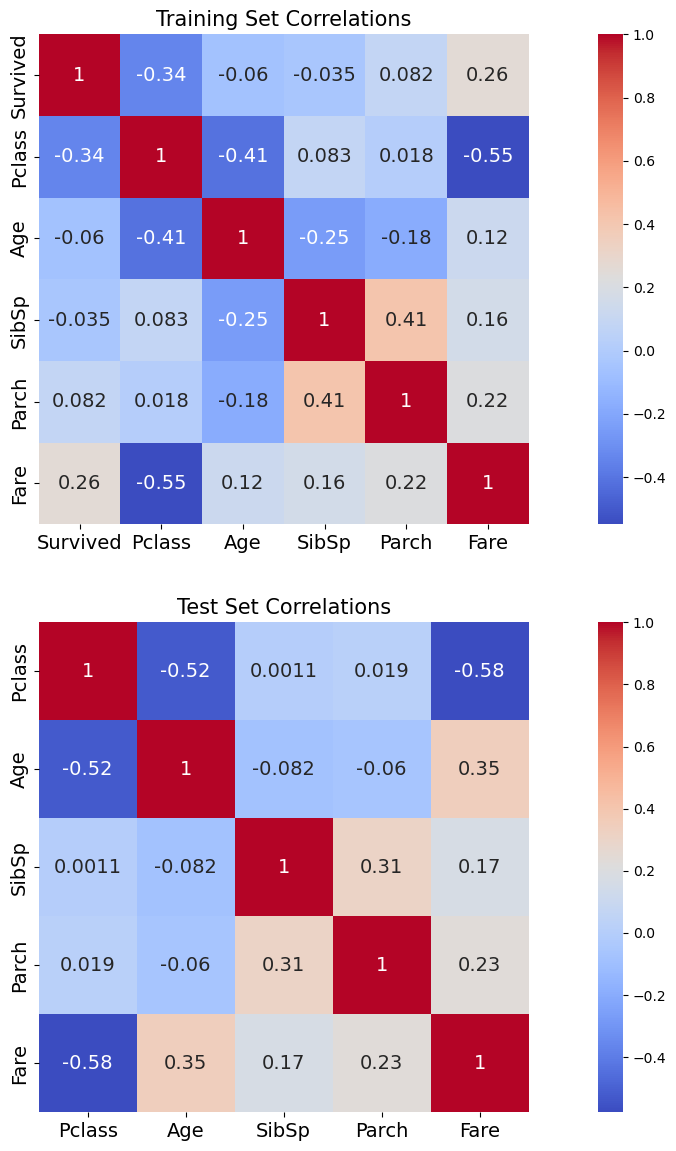

In [218]:
# create heatmaps
fig, axs = plt.subplots(nrows=2, figsize=(18, 14))

sns.heatmap(train_data.drop(columns=categorical_features).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(test_data.drop(columns=categorical_features).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

In [219]:
# removing categorical features for correlation
train_data_corr = train_data.drop(columns=['Name', 'Ticket', 'Sex', 'Embarked'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
test_data_corr = test_data.drop(columns=['Name', 'Ticket', 'Sex', 'Embarked'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

In [220]:
# rename columns and remove values, where correlation == 1
train_data_corr.rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation coefficient"}, inplace=True)
train_data_corr = train_data_corr.drop(train_data_corr[train_data_corr['Correlation coefficient'] == 1.0].index)

test_data_corr.rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation coefficient"}, inplace=True)
test_data_corr = test_data_corr.drop(test_data_corr[test_data_corr['Correlation coefficient'] == 1.0].index)

In [221]:
# train high correlations
train_corr = train_data_corr['Correlation coefficient'] > 0.1
train_data_corr[train_corr]

,Feature_1,Feature_2,Correlation coefficient
6,Fare,Pclass,0.549500
7,Pclass,Fare,0.549500
8,Parch,SibSp,0.414838
9,SibSp,Parch,0.414838
10,Age,Pclass,0.413583
11,Pclass,Age,0.413583
12,Survived,Pclass,0.338481
13,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
15,Survived,Fare,0.257307


In [222]:
# test high correlations
test_corr = test_data_corr['Correlation coefficient'] > 0.1
test_data_corr[test_corr]

,Feature_1,Feature_2,Correlation coefficient
5,Fare,Pclass,0.577487
6,Pclass,Fare,0.577487
7,Pclass,Age,0.524907
8,Age,Pclass,0.524907
9,Age,Fare,0.346706
10,Fare,Age,0.346706
11,Parch,SibSp,0.306895
12,SibSp,Parch,0.306895
13,Fare,Parch,0.230409
14,Parch,Fare,0.230409


Correlations between features and target

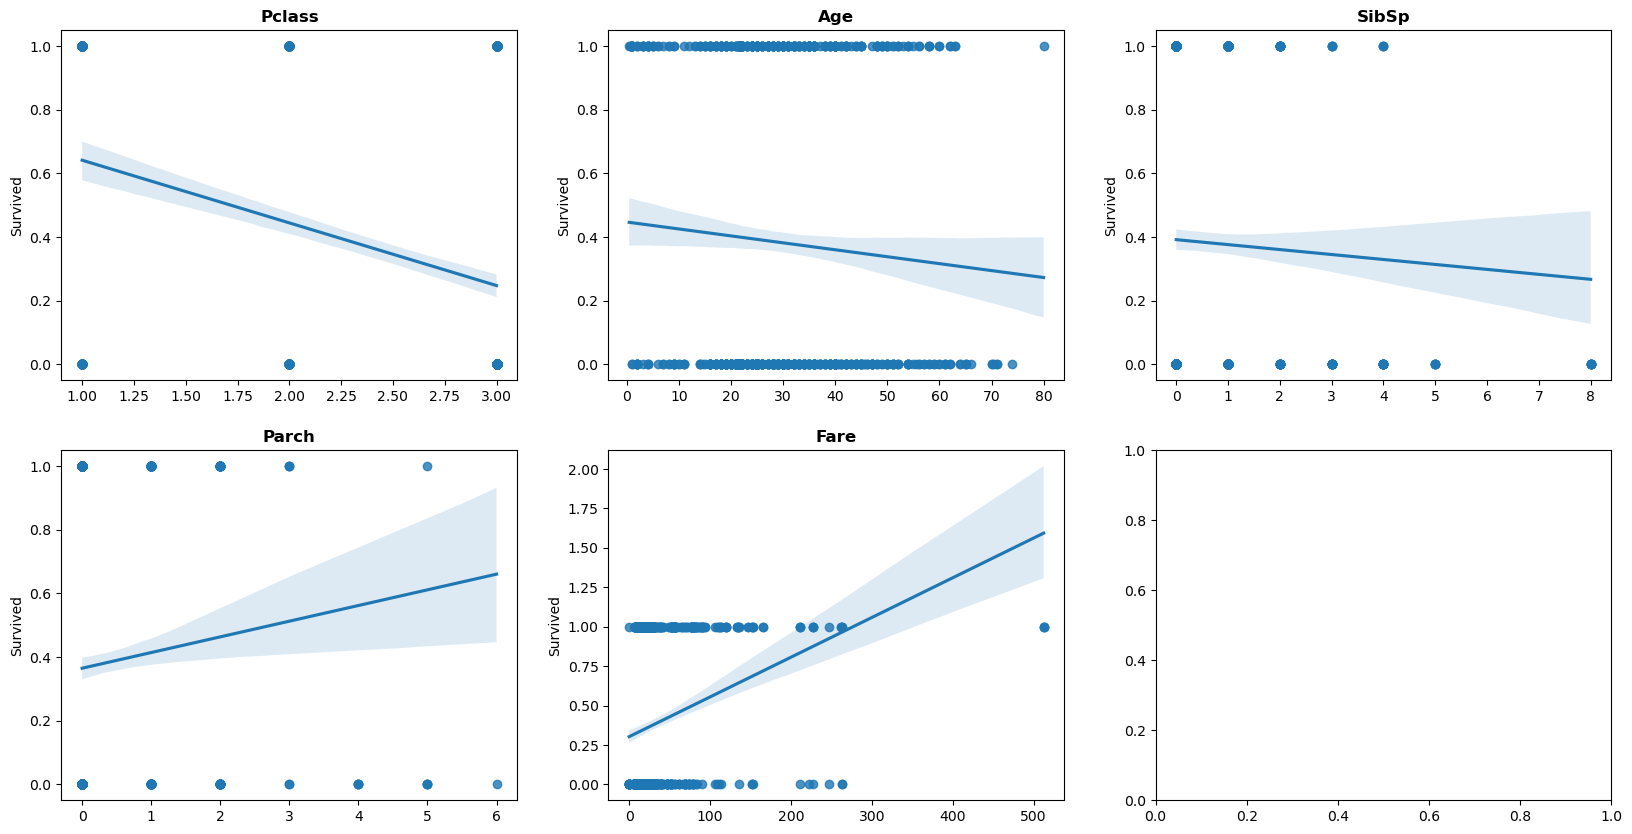

In [223]:
_, axis = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
sns.regplot(data=train_data, x='Pclass', y='Survived', ax=axis[0,0])
axis[0,0].set_title('Pclass', fontweight='bold')
axis[0,0].set_xlabel('')

sns.regplot(data=train_data, x='Age', y='Survived', ax=axis[0,1])
axis[0,1].set_title('Age', fontweight='bold')
axis[0,1].set_xlabel('')

sns.regplot(data=train_data, x='SibSp', y='Survived', ax=axis[0,2])
axis[0,2].set_title('SibSp', fontweight='bold')
axis[0,2].set_xlabel('')

sns.regplot(data=train_data, x='Parch', y='Survived', ax=axis[1,0])
axis[1,0].set_title('Parch', fontweight='bold')
axis[1,0].set_xlabel('')

sns.regplot(data=train_data, x='Fare', y='Survived', ax=axis[1,1])
axis[1,1].set_title('Fare', fontweight='bold')
axis[1,1].set_xlabel('')

plt.show()

Deleting some non-informative features

In [224]:
train_data = train_data.drop(columns=['Name', 'Ticket'])
test_data = test_data.drop(columns=['Name', 'Ticket'])

# Target distribution

In [225]:
survived = train_data['Survived'].value_counts()[1]
not_survived = train_data['Survived'].value_counts()[0]
survived_per = survived / train_data.shape[0] * 100
not_survived_per = not_survived / train_data.shape[0] * 100
print(f"Survived: {survived} - {survived_per:.2f}%, non-survived: {not_survived} - {not_survived_per:.2f}%")

Survived: 342 - 38.38%, non-survived: 549 - 61.62%


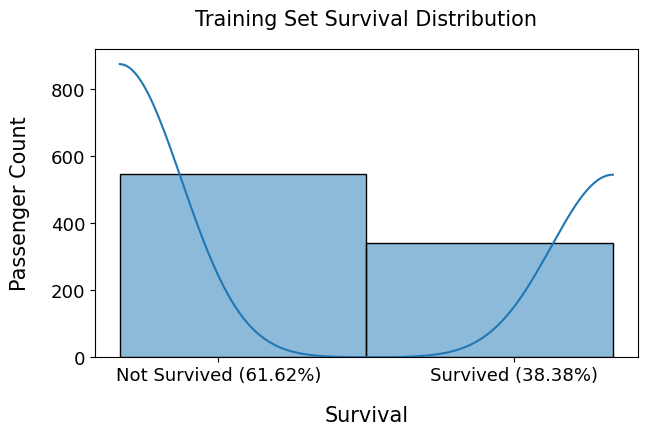

In [226]:
plt.figure(figsize=(7, 4))
sns.histplot(train_data['Survived'], bins=2 , kde=True)

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0.2, 0.8), [f"Not Survived ({not_survived_per:.2f}%)", f"Survived ({survived_per:.2f}%)"])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

# 2. Feature engineering

* Adding feature 'Family members'

In [227]:
train_data['Family_members'] = train_data['SibSp'] + train_data['Parch']
test_data['Family_members'] = test_data['SibSp'] + test_data['Parch']

* Adding feature 'Fare_range' based on percentilies

In [228]:
train_data['Fare'].describe(percentiles=[.25, .5, .75])

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [229]:
train_data['Fare_range'] = pd.cut(train_data['Fare'],
                                  bins=[0.0, 7.91, 14.45, 31, float('inf')],
                                  labels=['Cheap', 'Middle', 'Expensive', 'Very expensive'],
                                  right=False) # this is to include 0 in the range

test_data['Fare_range'] = pd.cut(test_data['Fare'],
                                  bins=[0.0, 7.91, 14.45, 31, float('inf')],
                                  labels=['Cheap', 'Middle', 'Expensive', 'Very expensive'],
                                  right=False)

# 3. Encoding categorical features

In [230]:
# Create columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories=[['Cheap', 'Middle', 'Expensive', 'Very expensive']]), ['Fare_range']),
        ('one_hot_encoder', OneHotEncoder(), ['Sex', 'Embarked', 'Pclass'])
    ])

# Create pipeline
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor)
    ])

In [232]:
# Apply the pipeline to DataFrame
train_data_transf = pipeline.fit_transform(train_data)
test_data_transf = pipeline.transform(test_data)

# Get column names after modification
# ordinal_encoder_categories = pipeline.named_steps['preprocessor'].named_transformers_['ordinal_encoder'].categories_[0]
one_hot_encoder_categories = pipeline.named_steps['preprocessor'].named_transformers_['one_hot_encoder'].get_feature_names_out(['Sex', 'Embarked', 'Pclass'])

# Convert the result back to DataFrame
train_data_transf = pd.DataFrame(train_data_transf, columns= ['Fare_Range'] + list(one_hot_encoder_categories))
test_data_transf = pd.DataFrame(test_data_transf, columns= ['Fare_Range'] + list(one_hot_encoder_categories))

# Set indexes
train_data_transf.index += 1
test_data_transf.index += 892

# Create a list of all column names
columns_train = list(train_data.columns) + list(train_data_transf.columns)
columns_test = list(test_data.columns) + list(test_data_transf.columns)

# Concatenate initial data with encoded data
train_data = pd.concat([train_data, train_data_transf], axis=1, ignore_index=True)
test_data = pd.concat([test_data, test_data_transf], axis=1, ignore_index=True)

# Assign column names
train_data.columns = columns_train
test_data.columns = columns_test

In [234]:
# Delete previously encoded columns
train_data.drop(columns=['Sex', 'Embarked', 'Pclass', 'Fare_range'], inplace=True)
test_data.drop(columns=['Sex', 'Embarked', 'Pclass', 'Fare_range'], inplace=True)

# 4. Splitting data into train, val and test 

In [235]:
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']
# split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

X_test = test_data

In [236]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 14), (179, 14), (712,), (179,))

# 5. Scaling features

In [237]:
scaler = MinMaxScaler()
# normalize the data based on X_train
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# convert normalized data into dataframes
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_val = pd.DataFrame(X_val_norm, columns=X_train.columns)
X_test = pd.DataFrame(X_test_norm, columns=X_train.columns)

In [238]:
X_train

,Age,SibSp,Parch,Fare,Family_members,Fare_Range,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.396833,0.125,0.166667,0.030254,0.2,0.666667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.421965,0.125,0.000000,0.040989,0.1,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.233476,0.000,0.000000,0.015924,0.0,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.233476,0.375,0.333333,0.513342,0.5,1.000000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.308872,0.125,0.000000,0.030254,0.1,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.258608,0.000,0.166667,0.150855,0.1,1.000000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
708,0.522493,0.125,0.000000,0.050749,0.1,0.666667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
709,0.673285,0.125,0.500000,0.044893,0.4,0.666667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
710,0.384267,0.000,0.333333,0.321798,0.2,1.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# 6. Modeling 

* 1. Logistic regression

* 2. SVC

* 3. RandomForest

* 4. Boosting